In [11]:
#@title ✅ Week 8 Track C — FinSynth Multimodal Router (Speech + Visualization + QA)
import time, json
import matplotlib.pyplot as plt
import pandas as pd
import requests
!pip install gTTS -q

# --- FinSynth mini dataset ---
df = pd.DataFrame({
    "year": [2023, 2024, 2025, 2026],
    "stock_index": [4200, 4650, 4900, 5250],
    "energy_price": [70, 75, 82, 88],
    "ev_sales": [3.2, 4.1, 5.6, 6.8]
})

print("✅ FinSynth dataset loaded.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 8.0 MB/s eta 0:00:00
✅ FinSynth dataset loaded.


In [14]:

# --- Step 1: Route Detector ---
def route(query: str) -> str:
    q = query.lower()
    if any(k in q for k in ["plot", "chart", "visualize", "show", "graph"]):
        return "viz"
    if any(k in q for k in ["audio", "speak", "voice", "listen"]):
        return "speech"
    return "qa"

In [15]:
# --- Step 2: Speech Tool (uses your Track A pipeline) ---
def tool_speech(query: str):
    from gtts import gTTS
    text = f"FinSynth voice module activated for: {query}"
    out = "speech_reply.mp3"
    gTTS(text).save(out)
    return {"mode": "speech", "reply": text, "audio_file": out}

In [16]:
# --- Step 3: Visualization Tool (from Track B) ---
def tool_viz(query: str):
    q = query.lower()
    plt.figure()
    if "stock" in q:
        plt.plot(df["year"], df["stock_index"], marker="o")
        plt.title("Stock Market Index Over Time")
        plt.xlabel("Year"); plt.ylabel("Stock Index")
    elif "energy" in q:
        plt.plot(df["year"], df["energy_price"], marker="o")
        plt.title("Energy Price Trend (USD/barrel)")
        plt.xlabel("Year"); plt.ylabel("Price")
    elif "ev" in q or "vehicle" in q:
        plt.plot(df["year"], df["ev_sales"], marker="o")
        plt.title("EV Sales Growth (Millions)")
        plt.xlabel("Year"); plt.ylabel("EV Sales")
    else:
        plt.plot(df["year"], df["stock_index"], label="Stock Index")
        plt.plot(df["year"], df["energy_price"], label="Energy Price")
        plt.legend()
        plt.title("Stock vs Energy Trends")
    plt.grid(True)
    plt.show()
    return {"mode": "viz", "note": "Visualization generated using Matplotlib"}


In [17]:
# --- Step 4: QA Tool (connects to your FinSynth backend) ---
def tool_project_qa(query: str):
    try:
        r = requests.post("http://127.0.0.1:8000/qa", json={"text": query}, timeout=10)
        return r.json()
    except Exception as e:
        return {"mode": "qa", "error": str(e), "answer": "(Fallback) Market shows stable trends overall."}

In [18]:
# --- Step 5: Guardrails (safety filter) ---
BLOCK = ["malware", "ssn", "phi", "password", "hack"]
def guardrails(q: str) -> bool:
    return not any(b in q.lower() for b in BLOCK)

In [19]:
# --- Step 6: Orchestrator ---
def run(query: str):
    if not guardrails(query):
        return {"error": "Refused by guardrails (unsafe query)."}
    route_type = route(query)
    print(f"🧭 Routed to: {route_type.upper()}")
    if route_type == "viz":
        return tool_viz(query)
    elif route_type == "speech":
        return tool_speech(query)
    else:
        return tool_project_qa(query)


🧠 Query: Plot the stock market trend by year
🧭 Routed to: VIZ


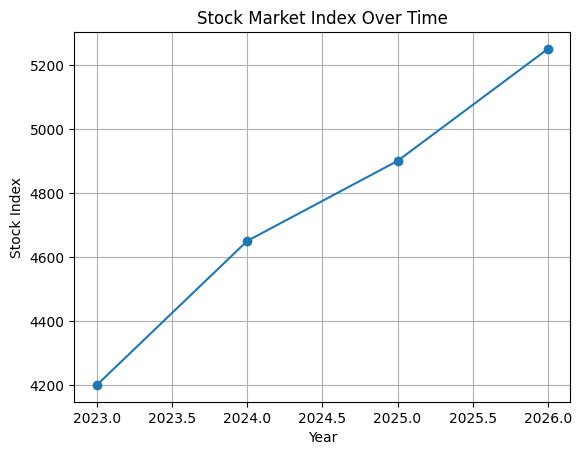

→ Result: {
  "mode": "viz",
  "note": "Visualization generated using Matplotlib"
}

🧠 Query: Can you visualize energy growth?
🧭 Routed to: VIZ


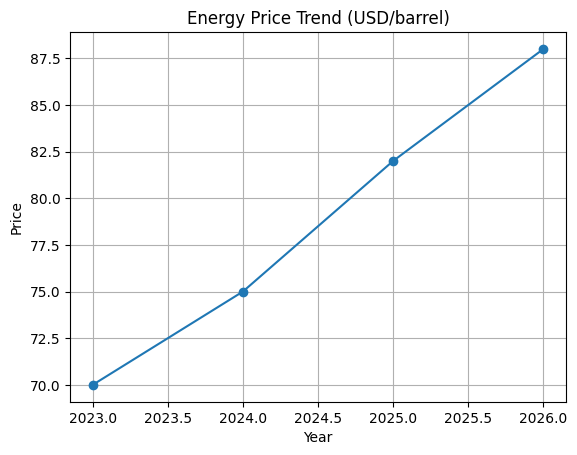

→ Result: {
  "mode": "viz",
  "note": "Visualization generated using Matplotlib"
}

🧠 Query: Speak this response as audio
🧭 Routed to: SPEECH
→ Result: {
  "mode": "speech",
  "reply": "FinSynth voice module activated for: Speak this response as audio",
  "audio_file": "speech_reply.mp3"
}

🧠 Query: What is the forecast for EV adoption?
🧭 Routed to: QA
→ Result: {
  "mode": "qa",
  "error": "HTTPConnectionPool(host='127.0.0.1', port=8000): Max retries exceeded with url: /qa (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x79d94bf10710>: Failed to establish a new connection: [Errno 111] Connection refused'))",
  "answer": "(Fallback) Market shows stable trends overall."
}


In [21]:
# --- Step 7: Demo Queries ---
demo_queries = [
    "Plot the stock market trend by year",
    "Can you visualize energy growth?",
    "Speak this response as audio",
    "What is the forecast for EV adoption?"
]

for q in demo_queries:
    print("\n🧠 Query:", q)
    result = run(q)
    print("→ Result:", json.dumps(result, indent=2))